In [12]:
import pandas as pd
import numpy as np
import pickle

import keras
import keras.utils

from keras.callbacks import TensorBoard
from keras import optimizers

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dense,LSTM,Dropout,Bidirectional,GRU, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D

from keras.utils import to_categorical
from keras.layers import Flatten

# from keras.utils import pad_sequences
from keras_preprocessing import sequence

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
## LOAD SAVED DATA
# load data
train_data = pd.read_pickle('processed_train_data_v2.p')
val_data = pd.read_pickle('processed_val_data_v2.p')
test_data = pd.read_pickle('processed_test_data_v2.p')

# load vocab dicts
vocabulary_dict_custom = pickle.load(open('vocabulary_statement_custom.p', 'rb'))
vocabulary_dict_spacy = pickle.load(open('vocabulary_statement_spacy.p', 'rb'))
# vocab_length = len(vocabulary_dict_custom)
print("Length of the vocabulary dictionaries:", len(vocabulary_dict_custom), len(vocabulary_dict_spacy))

# load Glove embeddings matrixes
embedding_matrix_custom_100d = np.load('embedding_matrix_custom_100d.npy')
embedding_matrix_spacy_100d = np.load('embedding_matrix_spacy_100d.npy')
embedding_matrix_custom_300d = np.load('embedding_matrix_custom_300d.npy')
embedding_matrix_spacy_300d = np.load('embedding_matrix_spacy_300d.npy')
print("Shape of the embedding matrixes:", embedding_matrix_custom_100d.shape, embedding_matrix_spacy_300d.shape)

Length of the vocabulary dictionaries: 9606 9495
Shape of the embedding matrixes: (9607, 100) (9496, 300)


In [94]:
label_map = {'pants-fire':0, 'false':1, 'barely-true':2, 'half-true':3, 'mostly-true':4, 'true':5}

In [95]:
train_data['output'] = train_data['label'].apply(lambda x: label_map[x])
val_data['output'] = val_data['label'].apply(lambda x: label_map[x])
test_data['output'] = test_data['label'].apply(lambda x: label_map[x])

In [96]:
train_data['output'].value_counts()

3    2114
1    1995
4    1962
5    1676
2    1654
0     839
Name: output, dtype: int64

In [4]:
# Load DEP_dict
with open('dep_dict.p', 'rb') as f:
    dep_dict_fine, dep_dict_custom = pickle.load(f)

In [5]:
# Load POS dict
with open('pos_dicts.p', 'rb') as f:
    pos_dict_custom, pos_dict_fine, pos_dict_fine_merged, pos_dict_default = pickle.load(f) #pos_dict_default is not used

In [6]:
train_data

,index,id,label,statement,subject,speaker,job-title,party,barely-true-counts,false-counts,...,pos-id-fine-merged,pos-id-custom,dep-id-fine,dep-id-custom,statement-customswr,statement-spacyswr,job-id-jaccard,party-id-jaccard,context-id-jaccard,subject-id-jaccard
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,republican,0.0,1.0,...,"[2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]","[2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]","[8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]","[7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]",say annies list political group support third ...,say annies list political group support trimes...,2,0,13,2
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,democrat,0.0,0.0,...,"[5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...","[8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...","[8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...","[11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...,6,1,0,5
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,democrat,70.0,71.0,...,"[3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...","[9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...","[7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...","[4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...,2,1,3,5
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,unknown,none,7.0,19.0,...,"[3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]","[1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]","[7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]","[4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...,0,2,0,0
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,democrat,15.0,9.0,...,"[5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]","[15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]","[8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]","[5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]",economic turnaround start end term,economic turnaround start end term,0,1,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,unknown,none,0.0,1.0,...,"[5, 2, 5, 1, 3, 5, 3, 3, 5, 3, 5, 5, 2, 3, 5, ...","[6, 2, 15, 3, 1, 5, 1, 1, 5, 9, 8, 6, 2, 1, 5,...","[8, 8, 8, 3, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, ...","[11, 7, 5, 8, 11, 2, 4, 3, 2, 3, 11, 11, 11, 1...",be large number shark attack florida than be c...,large number shark attack florida case voter f...,0,2,3,0
10236,10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,unknown,republican,0.0,0.0,...,"[5, 2, 4, 2, 5, 3, 5, 5, 5, 3, 5, 3, 3, 5, 5, ...","[9, 12, 4, 2, 15, 1, 5, 15, 15, 9, 11, 9, 1, 1...","[1, 8, 8, 8, 8, 8, 8, 8, 4, 4, 8, 7, 8, 8, 6, ...","[6, 10, 11, 7, 5, 11, 2, 5, 11, 11, 1, 4, 3, 1...",democrats have now become party atlanta metro ...,democrats party atlanta metro area black,0,0,3,3
10237,10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,unknown,republican,4.0,11.0,...,"[2, 5, 3, 5, 3, 3, 5, 2, 5, 3, 3, 5, 3, 5, 2, ...","[2, 15, 1, 5, 9, 9, 6, 2, 5, 9, 9, 11, 9, 11, ...","[8, 8, 1, 8, 7, 8, 1, 8, 8, 7, 8, 8, 8, 8, 8, ...","[7, 5, 6, 2, 4, 3, 6, 11, 2, 4, 3, 1, 11, 1, 1...",say alternative social security operate galves...,say alternative social security operate galves...,0,0,0,3
10238,10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,unknown,democrat,3.0,1.0,...,"[5, 2

In [26]:
train_data = train_data.rename(columns={'job-title-id-kmeans': 'job-id-kmeans'})

In [16]:
val_data = val_data.rename(columns=
                               {'preprocessed-context-clustered': 'context-id-kmeans',
                                'preprocessed-job-title-clustered': 'job-id-kmeans',
                                'preprocessed-party-clustered': 'party-id-kmeans',
                                'preprocessed-subject-clustered': 'subject-id-kmeans'
                                }
                               )

test_data = test_data.rename(columns=
                               {'preprocessed-context-clustered': 'context-id-kmeans',
                                'preprocessed-job-title-clustered': 'job-id-kmeans',
                                'preprocessed-party-clustered': 'party-id-kmeans',
                                'preprocessed-subject-clustered': 'subject-id-kmeans'
                                }
                               )

In [18]:
# EXPORT data as pickle
train_data.to_pickle('processed_train_data_v2.p')
val_data.to_pickle('processed_val_data_v2.p')
test_data.to_pickle('processed_test_data_v2.p')

In [19]:
# IMPORT v2 data
train_data = pd.read_pickle('processed_train_data_v2.p')
val_data = pd.read_pickle('processed_val_data_v2.p')
test_data = pd.read_pickle('processed_test_data_v2.p')

In [124]:
# EXPORT DATA as p
train_data.to_pickle('processed_train_data_v2.p')
val_data.to_pickle('processed_val_data_v2.p')
test_data.to_pickle('processed_test_data_v2.p')

In [25]:
train_data.columns

Index(['index', 'id', 'label', 'statement', 'subject', 'speaker', 'job-title',
       'party', 'barely-true-counts', 'false-counts', 'half-true-counts',
       'mostly-true-counts', 'pants-on-fire-counts', 'context', 'output',
       'preprocessed-subject', 'preprocessed-context', 'context-id-kmeans',
       'preprocessed-job-title', 'preprocessed-party', 'party-id-kmeans',
       'job-title-id-kmeans', 'subject-id-kmeans', 'pos-id-fine',
       'pos-id-fine-merged', 'pos-id-custom', 'dep-id-fine', 'dep-id-custom',
       'statement-customswr', 'statement-spacyswr', 'job-id-jaccard',
       'party-id-jaccard', 'context-id-jaccard', 'subject-id-jaccard'],
      dtype='object')

In [14]:
val_data.columns

Index(['index', 'id', 'label', 'statement', 'subject', 'speaker', 'job-title',
       'party', 'barely-true-counts', 'false-counts', 'half-true-counts',
       'mostly-true-counts', 'pants-on-fire-counts', 'context', 'output',
       'preprocessed-job-title', 'preprocessed-context',
       'preprocessed-context-clustered', 'preprocessed-job-title-clustered',
       'preprocessed-subject', 'preprocessed-subject-clustered',
       'preprocessed-party', 'preprocessed-party-clustered', 'pos-id-fine',
       'pos-id-fine-merged', 'pos-id-custom', 'dep-id-fine', 'dep-id-custom',
       'statement-customswr', 'statement-spacyswr', 'job-id-jaccard',
       'party-id-jaccard', 'context-id-jaccard', 'subject-id-jaccard'],
      dtype='object')

In [21]:
val_data.columns

Index(['index', 'id', 'label', 'statement', 'subject', 'speaker', 'job-title',
       'party', 'barely-true-counts', 'false-counts', 'half-true-counts',
       'mostly-true-counts', 'pants-on-fire-counts', 'context', 'output',
       'preprocessed-job-title', 'preprocessed-context', 'context-id-kmeans',
       'job-id-kmeans', 'preprocessed-subject', 'subject-id-kmeans',
       'preprocessed-party', 'party-id-kmeans', 'pos-id-fine',
       'pos-id-fine-merged', 'pos-id-custom', 'dep-id-fine', 'dep-id-custom',
       'statement-customswr', 'statement-spacyswr', 'job-id-jaccard',
       'party-id-jaccard', 'context-id-jaccard', 'subject-id-jaccard'],
      dtype='object')

In [97]:
## OUTPUT
Y_train = train_data['output']
Y_train = keras.utils.to_categorical(Y_train, num_classes=6)

Y_val = val_data['output']
Y_val = keras.utils.to_categorical(Y_val, num_classes=6)

Y_test = test_data['output']
Y_test = keras.utils.to_categorical(Y_test, num_classes=6)

In [98]:
# One-hot encode the metadata columns

# train sets
context_id_kmeans_encoded = to_categorical(train_data['context-id-kmeans'])
subject_id_kmeans_encoded = to_categorical(train_data['subject-id-kmeans'])
job_id_kmeans_encoded = to_categorical(train_data['job-id-kmeans'])
party_id_kmeans_encoded = to_categorical(train_data['party-id-kmeans'])

context_id_jaccard_encoded = to_categorical(train_data['context-id-jaccard'])
subject_id_jaccard_encoded = to_categorical(train_data['subject-id-jaccard'])
job_id_jaccard_encoded = to_categorical(train_data['job-id-jaccard'])
party_id_jaccard_encoded = to_categorical(train_data['party-id-jaccard'])

# validation sets
val_context_id_kmeans_encoded = to_categorical(val_data['context-id-kmeans'])
val_subject_id_kmeans_encoded = to_categorical(val_data['subject-id-kmeans'])
val_job_id_kmeans_encoded = to_categorical(val_data['job-id-kmeans'])
val_party_id_kmeans_encoded = to_categorical(val_data['party-id-kmeans'])

val_context_id_jaccard_encoded = to_categorical(val_data['context-id-jaccard'])
val_subject_id_jaccard_encoded = to_categorical(val_data['subject-id-jaccard'])
val_job_id_jaccard_encoded = to_categorical(val_data['job-id-jaccard'])
val_party_id_jaccard_encoded = to_categorical(val_data['party-id-jaccard'])

# test sets
test_context_id_kmeans_encoded = to_categorical(test_data['context-id-kmeans'])
test_subject_id_kmeans_encoded = to_categorical(test_data['subject-id-kmeans'])
test_job_id_kmeans_encoded = to_categorical(test_data['job-id-kmeans'])
test_party_id_kmeans_encoded = to_categorical(test_data['party-id-kmeans'])

test_context_id_jaccard_encoded = to_categorical(test_data['context-id-jaccard'])
test_subject_id_jaccard_encoded = to_categorical(test_data['subject-id-jaccard'])
test_job_id_jaccard_encoded = to_categorical(test_data['job-id-jaccard'])
test_party_id_jaccard_encoded = to_categorical(test_data['party-id-jaccard'])

In [99]:
# Concatenate the one-hot encoded categorical columns for each comparison case:
# K-means comparison
X_train_meta_kmeans = np.hstack((context_id_kmeans_encoded, subject_id_kmeans_encoded, job_id_kmeans_encoded, party_id_kmeans_encoded))
X_val_meta_kmeans = np.hstack((val_context_id_kmeans_encoded, val_subject_id_kmeans_encoded, val_job_id_kmeans_encoded, val_party_id_kmeans_encoded))
X_test_meta_kmeans = np.hstack((test_context_id_kmeans_encoded, test_subject_id_kmeans_encoded, test_job_id_kmeans_encoded, test_party_id_kmeans_encoded))

# Jaccard comparison
X_train_meta_jaccard = np.hstack((context_id_jaccard_encoded, subject_id_jaccard_encoded, job_id_jaccard_encoded, party_id_jaccard_encoded))
X_val_meta_jaccard = np.hstack((val_context_id_jaccard_encoded, val_subject_id_jaccard_encoded, val_job_id_jaccard_encoded, val_party_id_jaccard_encoded))
X_test_meta_jaccard = np.hstack((test_context_id_jaccard_encoded, test_subject_id_jaccard_encoded, test_job_id_jaccard_encoded, test_party_id_jaccard_encoded))

In [ ]:
# # Dense Model for non-statement features (POS, DEP, metadata)
# def create_dense_model(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
#     dense = Dense(512, activation='relu')(inputs)
#     dense = Dense(256, activation='relu')(dense)
#     dense = Dense(256, activation='relu')(dense)
#     dense = Dropout(0.5)(dense)
#     dense = Dense(256, activation='relu')(dense)
#     dense = Dense(64, activation='relu')(dense)
#     dense = Dense(64, activation='relu')(dense)
#     dense = Dense(64, activation='relu')(dense)
#     dense = Dropout(0.5)(dense)
#     output = Dense(num_classes, activation='softmax')(dense)
#     model = Model(inputs=inputs, outputs=output)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [100]:
from keras.regularizers import l2
from keras.optimizers import Adam

def create_dense_model(input_shape, num_classes, learning_rate):
    inputs = Input(shape=input_shape)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(dense)
    model = Model(inputs=inputs, outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [101]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create ModelCheckpoint callback
model_checkpoint_jaccard = ModelCheckpoint(filepath='best_model_jaccard.h5', monitor='val_loss', save_best_only=True)
model_checkpoint_kmeans = ModelCheckpoint(filepath='best_model_kmeans.h5', monitor='val_loss', save_best_only=True)

## K-MEANS

In [102]:
num_classes = 6
# First training with learning_rate = 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
learning_rate = 0.0005
dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate)
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 2s 12ms/step - loss: 2.5710 - accuracy: 0.1943 - val_loss: 2.2704 - val_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1009 - accuracy: 0.1960 - val_loss: 1.9909 - val_accuracy: 0.2157
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9117 - accuracy: 0.2158 - val_loss: 1.8935 - val_accuracy: 0.2134
Epoch 4/150
80/80 [==============================] - 0s 6ms/step - loss: 1.8397 - accuracy: 0.2172 - val_loss: 1.8354 - val_accuracy: 0.2375
Epoch 5/150
80/80 [==============================] - 0s 6ms/step - loss: 1.8058 - accuracy: 0.2237 - val_loss: 1.8160 - val_accuracy: 0.2204
Epoch 6/150
80/80 [==============================] - 0s 6ms/step - loss: 1.7890 - accuracy: 0.2218 - val_loss: 1.8091 - val_accuracy: 0.2235
Epoch 7/150
80/80 [==============================] - 0s 6ms/step - loss: 1.7791 - accuracy: 0.2196 - val_loss: 1.7987 - val_accuracy: 0.2173
Epoch 8/150


In [106]:
num_classes = 6
# First training with learning_rate = 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
learning_rate = 0.0005
dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate)
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 2s 8ms/step - loss: 2.6137 - accuracy: 0.1997 - val_loss: 2.3408 - val_accuracy: 0.1931
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1733 - accuracy: 0.2125 - val_loss: 2.0611 - val_accuracy: 0.2142
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9764 - accuracy: 0.2183 - val_loss: 1.9325 - val_accuracy: 0.2305
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8861 - accuracy: 0.2166 - val_loss: 1.8772 - val_accuracy: 0.2204
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8384 - accuracy: 0.2216 - val_loss: 1.8461 - val_accuracy: 0.2040
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.8112 - accuracy: 0.2249 - val_loss: 1.8221 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7964 - accuracy: 0.2229 - val_loss: 1.8211 - val_accuracy: 0.2188
Epoch 8/150
8

In [107]:
from keras.models import load_model

# Load the best model from the saved checkpoint
best_model_kmeans = load_model('best_model_kmeans.h5')

# Make predictions using the best model
predictions = best_model_kmeans.predict(X_test_meta_kmeans)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)


40/40 [==============================] - 0s 2ms/step


In [108]:
from sklearn.metrics import accuracy_score

# Assuming you have the true labels of the test set in a variable called `Y_test`
true_labels = np.argmax(Y_test, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test set accuracy: {accuracy:.2f}')


Test set accuracy: 0.20


In [116]:
from keras.models import load_model

# Load the best model from the saved checkpoint
best_model_kmeans = load_model('best_model_kmeans.h5')

# Make predictions using the best model
predictions = best_model_kmeans.predict(X_test_meta_kmeans)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels of the test set in a variable called `Y_test`
true_labels = np.argmax(Y_test, axis=1)

# # Calculate the accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f'Test set accuracy: {accuracy:.2f}')
#
# # Calculate the precision (use `average` parameter to specify the type of averaging you want)
# precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
# print(f'Test set precision: {precision:.2f}')
#
# # Calculate the recall (use `average` parameter to specify the type of averaging you want)
# recall = recall_score(true_labels, predicted_labels, average='weighted')
# print(f'Test set recall: {recall:.2f}')
#
# # Calculate the F1 score (use `average` parameter to specify the type of averaging you want)
# f1 = f1_score(true_labels, predicted_labels, average='weighted')
# print(f'Test set F1 score: {f1:.2f}')

# # Make predictions using the best model
# predictions = best_model_kmeans.predict(X_test_meta_kmeans)

# Convert the predictions to class labels
# predicted_labels = np.argmax(predictions, axis=1)

Y_test = test_data['output']
Y_test = keras.utils.to_categorical(Y_test, num_classes=6)

# true_labels = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

print(conf_mat)

# # Plot the confusion matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()


40/40 [==============================] - 0s 2ms/step
[[  0  38   0  15  39   0]
 [  0 138   0  53  58   0]
 [  0 118   0  52  42   0]
 [  0 150   0  72  43   0]
 [  0 120   0  83  38   0]
 [  0 130   0  40  38   0]]


In [114]:
test_data['output'].value_counts()

3    265
1    249
4    241
2    212
5    208
0     92
Name: output, dtype: int64

In [93]:
print(Y_test)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


In [90]:
from sklearn.metrics import confusion_matrix

# Get the predictions from the model
y_pred = np.argmax(dense_model_kmeans.predict(X_test_meta_kmeans), axis=-1)

# Convert the one-hot encoded labels back to their original format
y_true = np.argmax(Y_test, axis=-1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(conf_matrix)

40/40 [==============================] - 0s 2ms/step
[[  0  23 194  48   0]
 [  0  17 184  40   0]
 [  0  45 190  65   0]
 [  0  31 181  37   0]
 [  0  23 144  45   0]]


In [77]:
# Second training with learning_rate = 0.001
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate = 0.001
dense_model_kmeans = create_dense_model(X_train_meta_kmeans.shape[1], num_classes, learning_rate) # Create a new model with fresh weights and updated learning rate
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 1s 8ms/step - loss: 2.2787 - accuracy: 0.2217 - val_loss: 1.8951 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7942 - accuracy: 0.2180 - val_loss: 1.7240 - val_accuracy: 0.2220
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6952 - accuracy: 0.2342 - val_loss: 1.6763 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6631 - accuracy: 0.2315 - val_loss: 1.6564 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6479 - accuracy: 0.2284 - val_loss: 1.6441 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6379 - accuracy: 0.2361 - val_loss: 1.6380 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6324 - accuracy: 0.2342 - val_loss: 1.6357 - val_accuracy: 0.2220
Epoch 8/150
8

In [123]:
train_data['pos-id-fine']

0        [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...
1        [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...
2        [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...
3         [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]
4               [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]
                               ...                        
10235    [16, 8, 16, 2, 10, 16, 10, 11, 16, 12, 16, 16,...
10236    [16, 8, 13, 7, 16, 10, 16, 16, 16, 12, 16, 12,...
10237    [9, 16, 10, 16, 12, 12, 16, 9, 16, 12, 12, 16,...
10238        [16, 6, 16, 12, 1, 10, 16, 6, 10, 16, 12, 16]
10239    [16, 12, 16, 16, 16, 9, 16, 10, 13, 13, 6, 16,...
Name: pos-id-fine, Length: 10240, dtype: object

## JACCARD

In [79]:
# First training with learning_rate = 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
learning_rate = 0.0005
dense_model_jaccard = create_dense_model(X_train_meta_jaccard.shape[1], num_classes, learning_rate)
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/150
80/80 [==============================] - 2s 8ms/step - loss: 2.5618 - accuracy: 0.2093 - val_loss: 2.2627 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 2.1135 - accuracy: 0.2168 - val_loss: 1.9631 - val_accuracy: 0.2188
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.9002 - accuracy: 0.2261 - val_loss: 1.8179 - val_accuracy: 0.2212
Epoch 4/150
80/80 [==============================] - 0s 4ms/step - loss: 1.7927 - accuracy: 0.2247 - val_loss: 1.7491 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 4ms/step - loss: 1.7390 - accuracy: 0.2348 - val_loss: 1.7118 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 4ms/step - loss: 1.7032 - accuracy: 0.2336 - val_loss: 1.6862 - val_accuracy: 0.2235
Epoch 7/150
80/80 [==============================] - 0s 4ms/step - loss: 1.6833 - accuracy: 0.2363 - val_loss: 1.6700 - val_accuracy: 0.2368
Epoch 8/150
8

In [120]:
# Second training with learning_rate = 0.001
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
learning_rate = 0.001
dense_model_jaccard = create_dense_model(X_train_meta_jaccard.shape[1], num_classes, learning_rate) # Create a new model with fresh weights and updated learning rate
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/50
80/80 [==============================] - 2s 9ms/step - loss: 2.3710 - accuracy: 0.1940 - val_loss: 2.0040 - val_accuracy: 0.2181
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 1.8989 - accuracy: 0.2107 - val_loss: 1.8313 - val_accuracy: 0.2336
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 1.8089 - accuracy: 0.2197 - val_loss: 1.7951 - val_accuracy: 0.2188
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7837 - accuracy: 0.2198 - val_loss: 1.7764 - val_accuracy: 0.2305
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7710 - accuracy: 0.2173 - val_loss: 1.7681 - val_accuracy: 0.2321
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7649 - accuracy: 0.2149 - val_loss: 1.7644 - val_accuracy: 0.2383
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 1.7607 - accuracy: 0.2296 - val_loss: 1.7606 - val_accuracy: 0.2305
Epoch 8/50
80/80 [==

40/40 [==============================] - 0s 2ms/step
Test set accuracy: 0.23
Test set precision: 0.13
Test set recall: 0.23
Test set F1 score: 0.16


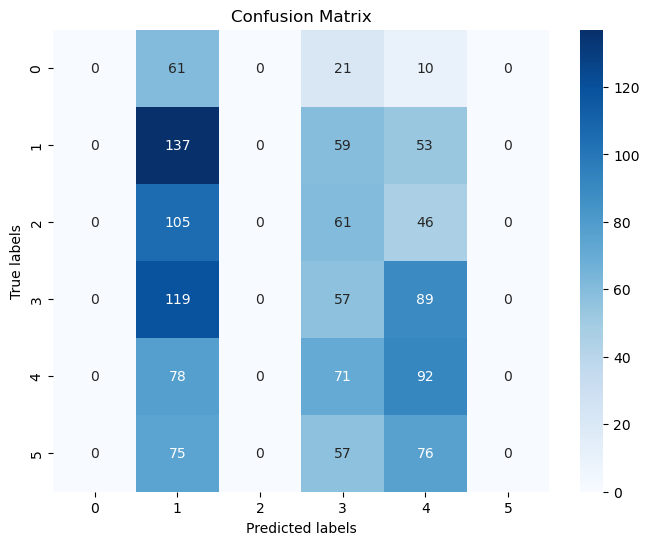

In [121]:
from keras.models import load_model

# Load the best model from the saved checkpoint
best_model_jaccard = load_model('best_model_jaccard.h5')

# Make predictions using the best model
predictions = best_model_jaccard.predict(X_test_meta_jaccard)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)



# Assuming you have the true labels of the test set in a variable called `Y_test`
true_labels = np.argmax(Y_test, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test set accuracy: {accuracy:.2f}')

# Calculate the precision (use `average` parameter to specify the type of averaging you want)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
print(f'Test set precision: {precision:.2f}')

# Calculate the recall (use `average` parameter to specify the type of averaging you want)
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Test set recall: {recall:.2f}')

# Calculate the F1 score (use `average` parameter to specify the type of averaging you want)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'Test set F1 score: {f1:.2f}')

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### INTIAL TESTING/TRAINING

In [71]:
# Train the model with callbacks for kmeans CATEGORICAL CROSS ENTROPY L2 NORM, CALLBACKS, LR=0.0005
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6094 - accuracy: 0.2452 - val_loss: 1.6165 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6093 - accuracy: 0.2452 - val_loss: 1.6164 - val_accuracy: 0.2220
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6083 - accuracy: 0.2456 - val_loss: 1.6161 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6087 - accuracy: 0.2459 - val_loss: 1.6175 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 6ms/step - loss: 1.6081 - accuracy: 0.2456 - val_loss: 1.6151 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 6ms/step - loss: 1.6072 - accuracy: 0.2456 - val_loss: 1.6147 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6074 - accuracy: 0.2446 - val_loss: 1.6183 - val_accuracy: 0.2220
Epoch 8/150
8

In [69]:
# Train the model with callbacks for kmeans CATEGORICAL CROSS ENTROPY L2 NORM, CALLBACKS, LR=0.001
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping, model_checkpoint_kmeans])

Epoch 1/150
80/80 [==============================] - 2s 11ms/step - loss: 2.3012 - accuracy: 0.2111 - val_loss: 1.8992 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 6ms/step - loss: 1.8012 - accuracy: 0.2226 - val_loss: 1.7282 - val_accuracy: 0.2220
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7021 - accuracy: 0.2260 - val_loss: 1.6783 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6644 - accuracy: 0.2264 - val_loss: 1.6545 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 6ms/step - loss: 1.6500 - accuracy: 0.2305 - val_loss: 1.6444 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 6ms/step - loss: 1.6376 - accuracy: 0.2348 - val_loss: 1.6385 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6333 - accuracy: 0.2373 - val_loss: 1.6352 - val_accuracy: 0.2220
Epoch 8/150


In [68]:
# Train the model with callbacks for jaccard CATEGORICAL CROSS ENTROPY L2 NORM, CALLBACKS, LR=0.001
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/150
80/80 [==============================] - 2s 9ms/step - loss: 2.2855 - accuracy: 0.2157 - val_loss: 1.8952 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 1.7936 - accuracy: 0.2232 - val_loss: 1.7168 - val_accuracy: 0.2196
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6960 - accuracy: 0.2301 - val_loss: 1.6715 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6623 - accuracy: 0.2360 - val_loss: 1.6491 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6482 - accuracy: 0.2393 - val_loss: 1.6459 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6396 - accuracy: 0.2369 - val_loss: 1.6366 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 1.6324 - accuracy: 0.2430 - val_loss: 1.6351 - val_accuracy: 0.2220
Epoch 8/150
8

In [59]:
# Train the model with callbacks for jaccard
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val), callbacks=[early_stopping, model_checkpoint_jaccard])

Epoch 1/150
80/80 [==============================] - 2s 8ms/step - loss: 1.0149 - accuracy: 0.2062 - val_loss: 0.5886 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 0.5330 - accuracy: 0.2193 - val_loss: 0.4711 - val_accuracy: 0.2220
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4733 - accuracy: 0.2127 - val_loss: 0.4493 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4540 - accuracy: 0.2190 - val_loss: 0.4405 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4442 - accuracy: 0.2246 - val_loss: 0.4356 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4399 - accuracy: 0.2294 - val_loss: 0.4326 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4360 - accuracy: 0.2346 - val_loss: 0.4308 - val_accuracy: 0.2220
Epoch 8/150
8

In [63]:
# Train mdoel with callbacks for kmeans
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val), callbacks=[early_stopping])

Epoch 1/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4216 - accuracy: 0.2454 - val_loss: 0.4214 - val_accuracy: 0.2220
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4213 - accuracy: 0.2462 - val_loss: 0.4219 - val_accuracy: 0.2220
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4213 - accuracy: 0.2448 - val_loss: 0.4202 - val_accuracy: 0.2220
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4211 - accuracy: 0.2453 - val_loss: 0.4208 - val_accuracy: 0.2220
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4209 - accuracy: 0.2450 - val_loss: 0.4207 - val_accuracy: 0.2220
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4206 - accuracy: 0.2434 - val_loss: 0.4206 - val_accuracy: 0.2220
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 0.4207 - accuracy: 0.2456 - val_loss: 0.4205 - val_accuracy: 0.2220
Epoch 8/150
8

In [52]:
# Train the K-means model YES L2 NORM DEFAULT LR
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=30, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val))

Epoch 1/30


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [43]:
# Train the K-means model YES L2 NORM DEFAULT LR
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=30, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val))

Epoch 1/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3733 - accuracy: 0.3753 - val_loss: 1.3347 - val_accuracy: 0.1893
Epoch 2/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3714 - accuracy: 0.3753 - val_loss: 1.4017 - val_accuracy: 0.1931
Epoch 3/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3710 - accuracy: 0.3805 - val_loss: 1.2948 - val_accuracy: 0.2017
Epoch 4/30
80/80 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.3789 - val_loss: 1.3937 - val_accuracy: 0.1893
Epoch 5/30
80/80 [==============================] - 0s 4ms/step - loss: 0.3684 - accuracy: 0.3853 - val_loss: 1.3730 - val_accuracy: 0.1963
Epoch 6/30
80/80 [==============================] - 0s 4ms/step - loss: 0.3672 - accuracy: 0.3896 - val_loss: 1.5697 - val_accuracy: 0.1955
Epoch 7/30
80/80 [==============================] - 0s 4ms/step - loss: 0.3667 - accuracy: 0.3884 - val_loss: 1.7194 - val_accuracy: 0.1916
Epoch 8/30
80/80 [==

In [44]:
# Train the Jaccard model YES L2 NORM DEFAULT LR
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val))

Epoch 1/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3269 - accuracy: 0.4371 - val_loss: 1.2994 - val_accuracy: 0.2321
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3272 - accuracy: 0.4327 - val_loss: 1.2738 - val_accuracy: 0.2360
Epoch 3/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3263 - accuracy: 0.4328 - val_loss: 1.3376 - val_accuracy: 0.2227
Epoch 4/150
80/80 [==============================] - 0s 4ms/step - loss: 0.3255 - accuracy: 0.4313 - val_loss: 1.4110 - val_accuracy: 0.2181
Epoch 5/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3261 - accuracy: 0.4359 - val_loss: 1.4133 - val_accuracy: 0.2383
Epoch 6/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3263 - accuracy: 0.4296 - val_loss: 1.3576 - val_accuracy: 0.2321
Epoch 7/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3267 - accuracy: 0.4329 - val_loss: 1.4195 - val_accuracy: 0.2290
Epoch 8/150
8

In [39]:
# Train the K-means model NO L2 NORM DEFAULT LR
dense_model_kmeans.fit(X_train_meta_kmeans, Y_train, epochs=30, batch_size=128, validation_data=(X_val_meta_kmeans, Y_val))

Epoch 1/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3900 - accuracy: 0.3421 - val_loss: 0.5322 - val_accuracy: 0.1947
Epoch 2/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3900 - accuracy: 0.3451 - val_loss: 0.5539 - val_accuracy: 0.1994
Epoch 3/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3874 - accuracy: 0.3420 - val_loss: 0.5450 - val_accuracy: 0.1970
Epoch 4/30
80/80 [==============================] - 0s 4ms/step - loss: 0.3857 - accuracy: 0.3580 - val_loss: 0.5517 - val_accuracy: 0.1931
Epoch 5/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3849 - accuracy: 0.3540 - val_loss: 0.6257 - val_accuracy: 0.1924
Epoch 6/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3845 - accuracy: 0.3579 - val_loss: 0.6276 - val_accuracy: 0.1916
Epoch 7/30
80/80 [==============================] - 0s 5ms/step - loss: 0.3834 - accuracy: 0.3566 - val_loss: 0.6909 - val_accuracy: 0.1986
Epoch 8/30
80/80 [==

In [41]:
# Train the Jaccard model NO L2 NORM DEFAULT LR
dense_model_jaccard.fit(X_train_meta_jaccard, Y_train, epochs=150, batch_size=128, validation_data=(X_val_meta_jaccard, Y_val))

Epoch 1/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3511 - accuracy: 0.4070 - val_loss: 0.6273 - val_accuracy: 0.2399
Epoch 2/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3518 - accuracy: 0.4033 - val_loss: 0.6363 - val_accuracy: 0.2329
Epoch 3/150
80/80 [==============================] - 0s 4ms/step - loss: 0.3504 - accuracy: 0.4065 - val_loss: 0.6416 - val_accuracy: 0.2305
Epoch 4/150
80/80 [==============================] - 0s 5ms/step - loss: 0.3494 - accuracy: 0.4097 - val_loss: 0.6747 - val_accuracy: 0.2422
Epoch 5/150
80/80 [==============================] - 0s 4ms/step - loss: 0.3483 - accuracy: 0.4093 - val_loss: 0.7185 - val_accuracy: 0.2368
Epoch 6/150
80/80 [==============================] - 0s 4ms/step - loss: 0.3492 - accuracy: 0.4109 - val_loss: 0.6636 - val_accuracy: 0.2539
Epoch 7/150
80/80 [==============================] - 0s 4ms/step - loss: 0.3504 - accuracy: 0.4065 - val_loss: 0.6437 - val_accuracy: 0.2516
Epoch 8/150
8

In [64]:


# BiLSTM-GRU Model for statement features
def create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, input_length):
    inputs = Input(shape=(input_length,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=input_length, trainable=False)(inputs)
    bilstm = Bidirectional(LSTM(50, return_sequences=True))(embedding)
    bigru = Bidirectional(GRU(50, return_sequences=True, return_state=True))[0](embedding)
    max_pool_lstm = GlobalMaxPooling1D()(bilstm)
    max_pool_gru = GlobalMaxPooling1D()(bigru)
    avg_pool_lstm = GlobalAveragePooling1D()(bilstm)
    avg_pool_gru = GlobalAveragePooling1D()(bigru)
    concat = Concatenate()([max_pool_lstm, max_pool_gru, avg_pool_lstm, avg_pool_gru])
    output = Dense(1, activation='sigmoid')(concat)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

# Create the Dense model
dense_input_shape = X_train_meta.shape[1]
dense_model = create_dense_model(dense_input_shape)

# Create the BiLSTM-GRU model
vocab_size = len(vocabulary_dict_custom) + 1
embedding_dim = 100
embedding_matrix = embedding_matrix_custom_100d
input_length = 30
bilstm_gru_model = create_bilstm_gru_model(vocab_size, embedding_dim, embedding_matrix, input_length)

# Train the models
dense_model.fit(X_train_meta, y_train, epochs=150, batch_size=128, validation_data=(X_val_meta, y_val))
bilstm_gru_model.fit(X_train_custom, y_train, epochs=10, batch_size=64, validation_data=(X_val_custom, y_val))

# Obtain predictions
dense_preds = dense_model.predict(X_test_meta)
bilstm_gru_preds = bilstm_gru_model.predict(X_test_custom)

# Ensemble voting
val_accuracies = [dense_model.evaluate(X_val_meta,


In [ ]:



def create_multi_input_model(input_shape_meta, vocab_size_pos, vocab_size_dep, num_classes, learning_rate):
    # Define separate input layers for each feature type
    input_meta = Input(shape=input_shape_meta, name="meta_input")
    input_pos = Input(shape=(None,), name="pos_input")
    input_dep = Input(shape=(None,), name="dep_input")

    # Define initial processing layers for each feature type
    meta_dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_meta)
    pos_embedding = Embedding(vocab_size_pos, 16)(input_pos)
    pos_flat = Flatten()(pos_embedding)
    dep_embedding = Embedding(vocab_size_dep, 16)(input_dep)
    dep_flat = Flatten()(dep_embedding)

    # Concatenate the outputs of the initial processing layers
    concat = Concatenate()([meta_dense, pos_flat, dep_flat])

    # Add additional Dense layers after concatenation
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(concat)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense)
    dense = Dropout(0.5)(dense)

    # Add the final output layer
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(dense)

    # Create and compile the model
    model = Model(inputs=[input_meta, input_pos, input_dep], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model